# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
data.Sex.value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [8]:
data[data.Survived==1].Sex.value_counts()

female    233
male      109
Name: Sex, dtype: int64

In [9]:
data[data.Survived==1].Sex.value_counts(normalize=True)

female    0.681287
male      0.318713
Name: Sex, dtype: float64

>As we can see, there were almost 65% of men and 35% of women in initial dataset. However, survided passengers in 68% cases were women! Thus, the gender tends to have a relationship with the survival.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

All dataset average age is: 29.69911764705882
All dataset median age is: 28.0


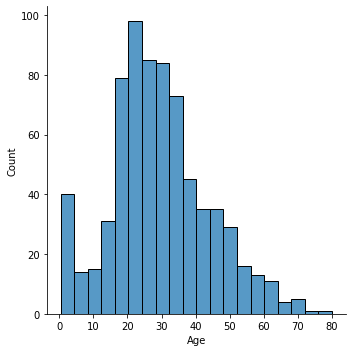

In [10]:
#age distribution of all dataset
print('All dataset average age is:', data.Age.mean())
print('All dataset median age is:', data.Age.median())
sns.displot(data['Age']);

The average age of survived passengers is: 28.343689655172415
The median age of survived passengers is: 28.0


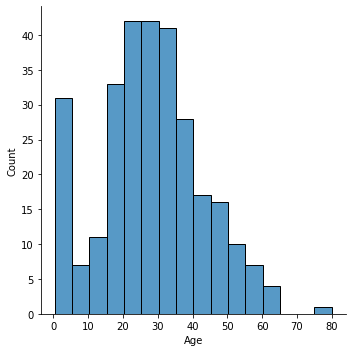

In [11]:
print('The average age of survived passengers is:', data[data.Survived==1].Age.mean())
print('The median age of survived passengers is:', data[data.Survived==1].Age.median())
sns.displot(data[data.Survived==1].Age);

The average age of deceased passengers is: 30.62617924528302
The median age of deceased passengers is: 28.0


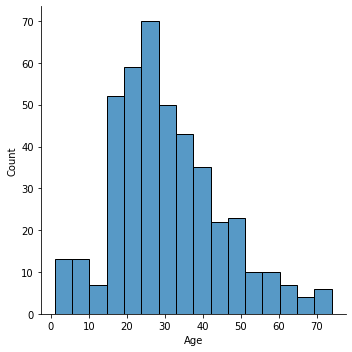

In [12]:
print('The average age of deceased passengers is:', data[data.Survived==0].Age.mean())
print('The median age of deceased passengers is:', data[data.Survived==0].Age.median())
sns.displot(data[data.Survived==0].Age);

>Yes, we can see that Age affects the result as well. As shown on distributions, more young passengers survived more often (it is especially noticeable in group of small children (0-5 y.o.) However, there is a big number of deceased people aged 20-30 y.o. So I think that this feature has an impact, but not so strong as the gender has.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

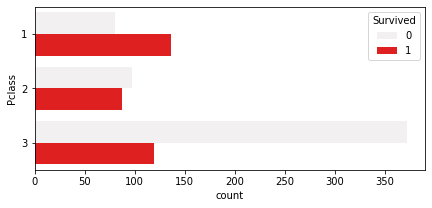

In [13]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="Pclass", hue="Survived", data=data, color="r");

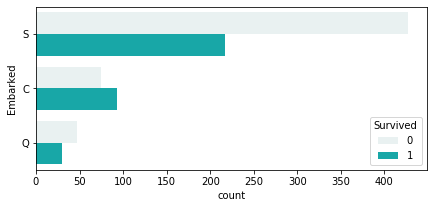

In [14]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="Embarked", hue="Survived", data=data, color="c");

> On the plots above we can see that the first class was "the safest". I found one interesting explanation.   
The Telegraph says: "More of the first class passengers survived because their cabins were closer to the lifeboats [just as much chance?] and many of the emigrants in third class died because their poor English meant they did not understand what was happening."

>The port of embarkation can affect the survival as well. On the one hand, there is a big disproportion between ports - most passengers embarked in Southampton (almost in 10 times more than in Queenstown). On the other hand, the "luckiness" of different ports varies a lot: for example, Cherbourg showed the best passenger survival rate.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [15]:
data.isnull().sum() * 100 / len(data)

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

>We can think about dropping Nan in Embarked column. But I think it is better to replace them by the most popular value (mode). Dropping Nan will deprive us of a big part of data (in case of Age and especialy Cabin columns). We can try to fill Nan in Age column by median age. In Cabin column we can either mark Nan as a missing value either use information from Pclass to fill Nan with supposed values.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [16]:
data['Age'].fillna(data['Age'].median(), inplace=True)

In [17]:
data['Embarked'].fillna(data['Embarked'].mode(), inplace=True)

>Let's encode Sex and Embarked features:

In [18]:
data['Sex'] = data['Sex'].apply(lambda x: 0 if x == 'female' else 1)
data['Embarked'] = data['Embarked'].apply(lambda x: 0 if x == 'S' else (1 if x == 'C' else 2))

In [19]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,0
888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,28.0,1,2,W./C. 6607,23.4500,NaN,0


>Now it's ok, we can choose features to train the model. I decided not to use Cabin because there is a lot of missing values and cabin numbers are related with Pclass. Name and ticket seem to be not very informative for the model. Thus, only 7 features remain:

In [20]:
y = data['Survived']
x = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

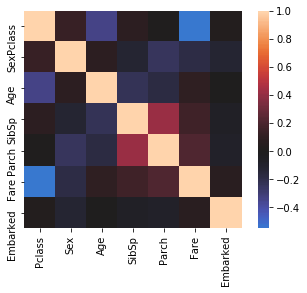

In [21]:
from seaborn import heatmap

heatmap(x.corr(method='pearson'), center=0, square=True)
plt.show()

>Now let's try 2 very simple models and measure their accuracy: 

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
main_model = LogisticRegression(solver='liblinear', penalty='l2', max_iter=2000)
main_model.fit(x,y)
print(cross_val_score(main_model, x, y, scoring='accuracy', cv=5).mean())

0.7946142740568702


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
knn = KNeighborsClassifier(n_neighbors=5)
print(cross_val_score(knn, x, y, scoring='accuracy', cv=5).mean())

0.6835540769568765


>It seems that LogisticRegression tends to show better result. But what if we add some preprocessing steps in our model?

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [24]:
data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

>First of all, it is important to notice that less people survived than died. As a little experiment, I loaded submission where all values were 0 (no one survived) and it got 0.62200. That's why I decided to use F1 score for the model evaluation as well. 


In [25]:
def f1_score_(precision, recall):
    f1 = 2*precision*recall/(precision+recall)
    return f1

In [26]:
main_model = LogisticRegression(solver='lbfgs', penalty='l2')
pipe_scaled = make_pipeline(StandardScaler(), main_model)
pipe_scaled.fit(x, y)
print('accuracy', cross_val_score(pipe_scaled, x, y, scoring='accuracy', cv=5).mean())
print('precision', cross_val_score(pipe_scaled, x, y, scoring='precision', cv=5).mean())
print('recall', cross_val_score(pipe_scaled, x, y, scoring='recall', cv=5).mean())
print('F1', f1_score_(cross_val_score(pipe_scaled, x, y, scoring='precision', cv=5).mean(), cross_val_score(pipe_scaled, x, y, scoring='recall', cv=5).mean()))

accuracy 0.7912434875400163
precision 0.7420360866954997
recall 0.7016197783461211
F1 0.7212621889734225


In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
pipe_scaled = make_pipeline(StandardScaler(), knn)
pipe_scaled.fit(x, y)
print('accuracy', cross_val_score(pipe_scaled, x, y, scoring='accuracy', cv=5).mean())
print('precision', cross_val_score(pipe_scaled, x, y, scoring='precision', cv=5).mean())
print('recall', cross_val_score(pipe_scaled, x, y, scoring='recall', cv=5).mean())
print('F1', f1_score_(cross_val_score(pipe_scaled, x, y, scoring='precision', cv=5).mean(), cross_val_score(pipe_scaled, x, y, scoring='recall', cv=5).mean()))

accuracy 0.813709120582512
precision 0.7867900891946401
recall 0.7104006820119352
F1 0.7466466220783087


>It seems that KNN is the leader now. But it got only 0.72727, while one of the simpliest logistic regressions got 0.76076. In general, after several attemps KNN generated worse, so I decided to tune LogisticRegression.

>Scaling improved Logreg accuracy a bit:0.76315. What if to try work with features? Parch and Sibsp are somewhat correlated (and Logreg doesn't like this), let's try to remove Parch.

In [28]:
x = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked']]

In [29]:
main_model = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2000)
main_model.fit(x,y)
print(cross_val_score(main_model, x, y, scoring='accuracy', cv=5).mean())

0.7957378695624883


In [30]:
main_model = LogisticRegression(solver='lbfgs', penalty='l2')
pipe_scaled = make_pipeline(StandardScaler(), main_model)
pipe_scaled.fit(x, y)
print('accuracy', cross_val_score(pipe_scaled, x, y, scoring='accuracy', cv=5).mean())
print('precision', cross_val_score(pipe_scaled, x, y, scoring='precision', cv=5).mean())
print('recall', cross_val_score(pipe_scaled, x, y, scoring='recall', cv=5).mean())
print('F1', f1_score_(cross_val_score(pipe_scaled, x, y, scoring='precision', cv=5).mean(), cross_val_score(pipe_scaled, x, y, scoring='recall', cv=5).mean()))

accuracy 0.7957378695624884
precision 0.7489424834935056
recall 0.7074168797953965
F1 0.7275876657567658


>It is better now. What about outliers? Let's take a closer look at Fare:

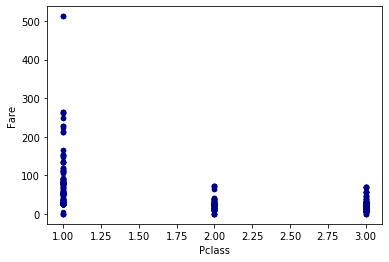

In [31]:
ax1 = data.plot.scatter(x='Pclass',
                      y='Fare',
                      c='DarkBlue')

In [32]:
data[data.Fare > 500]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",0,35.0,0,0,PC 17755,512.3292,NaN,1
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",1,36.0,0,1,PC 17755,512.3292,B51 B53 B55,1
738,1,1,"Lesurer, Mr. Gustave J",1,35.0,0,0,PC 17755,512.3292,B101,1


>There are 3 outliers that paid above 500. Do we have a right to remove them? We need to consider test data.

In [33]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
test_data[test_data.Fare > 500]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
343,1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


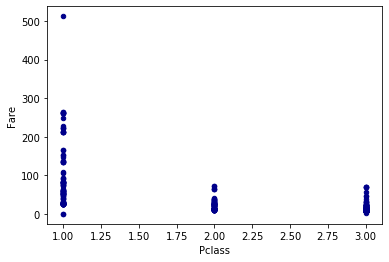

In [34]:
ax1 = test_data.plot.scatter(x='Pclass',
                      y='Fare',
                      c='DarkBlue')

>So in test dataset there is a person who is outlier as well. I think this information is important for the model, so decided not to remove such rows from the data.

>I tried different approaches to impove my model.
- RandomForestClassifier did not imporve my performance
- I included digits from tickets, scaled the model - but the score got worse
- KNN did not get results better than logreg

>I had a feeling that all my experiments with features and hyperparameters made the model worse. And then I decided to check whether THRESHOLD tuning could help me. If think logically, it could not be 0.5 - less people survived than died. So I started my experiments.

In [35]:
from sklearn.metrics import f1_score

In [36]:
clf = LogisticRegression(solver='lbfgs', penalty='l2')
clf.fit(x,y)
THRESHOLD = 0.65
preds = np.where(clf.predict_proba(x)[:,1] > THRESHOLD, 1, 0)
f1_score(y, preds)  

0.6948853615520282

In [37]:
clf = LogisticRegression(solver='lbfgs', penalty='l2')
clf.fit(x,y)
THRESHOLD = 0.5
preds = np.where(clf.predict_proba(x)[:,1] > THRESHOLD, 1, 0)
f1_score(y, preds) 

0.7343283582089553

In [38]:
pipe_scaled.fit(x, y)
THRESHOLD = 0.5
preds = np.where(pipe_scaled.predict_proba(x)[:,1] > THRESHOLD, 1, 0)
f1_score(y, preds)

0.7305389221556886

In [39]:
pipe_scaled.fit(x, y)
THRESHOLD = 0.65
preds = np.where(pipe_scaled.predict_proba(x)[:,1] > THRESHOLD, 1, 0)
f1_score(y, preds) 

0.706086956521739

>Now let's handle Nan in test data to make some submissions:

In [40]:
test_data.isnull().sum() * 100 / len(data)

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             9.652076
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.112233
Cabin          36.700337
Embarked        0.000000
dtype: float64

In [41]:
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

In [42]:
test_data['Sex'] = test_data['Sex'].apply(lambda x: 0 if x == 'female' else 1)
test_data['Embarked'] = test_data['Embarked'].apply(lambda x: 0 if x == 'S' else (1 if x == 'C' else 2))

In [43]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,2
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,27.0,0,0,A.5. 3236,8.0500,NaN,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0
416,1308,3,"Ware, Mr. Frederick",1,27.0,0,0,359309,8.0500,NaN,0


In [44]:
X_test = test_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked']]

> I tried different threshold values with clf (simple LogReg) and pipe_scaled (LogReg + Scaling). It turned out that pipe_scaled with threshold 0.65 gave 0.77990. And simple clf with the same threshold gave 0.78468.

In [45]:
#0.77990 
predictions = pipe_scaled.predict(X_test)
THRESHOLD = 0.65
preds = np.where(pipe_scaled.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [46]:
#0.78468 with this 
predictions = clf.predict(X_test)
THRESHOLD = 0.65
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [47]:
#0.78708
predictions = clf.predict(X_test)
THRESHOLD = 0.66
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

>0.66 is the optimal threshold value, it gives the max possible score. The submission has 111 survived persons. I had a score = 0.76555 given 0.7 threshold (lower number of survived). Lower thresholds=0.63, 0.62 gave 121 and 125 survived but the same score 0.78708. Thresholds=0.6 gave 0.77751 score. 

>I know that it seems like an experimental  search of the best trade-off solution. But I was surprised a bit because all my other attempts  with feature engineering, feature  selection, parameters tuning did not give such an improvement.

>Another good conclusion that I had - a more complex model (even with bigger cross-validated accuracy) does not mean a greater test score. In general, I appreciate all experiences that I got during this competition.

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [48]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': preds})
output.to_csv('my_submission.csv', index=False)

In [49]:
## my score
def kaggle_score(score):
    if score < 0.76:
        points = 0
    elif score < 0.78:
        points = 0.5
    elif score < 0.81:
        points = 1.0
    else:
        points = 2.5
    return points

In [50]:
kaggle_score(0.78708)

1.0

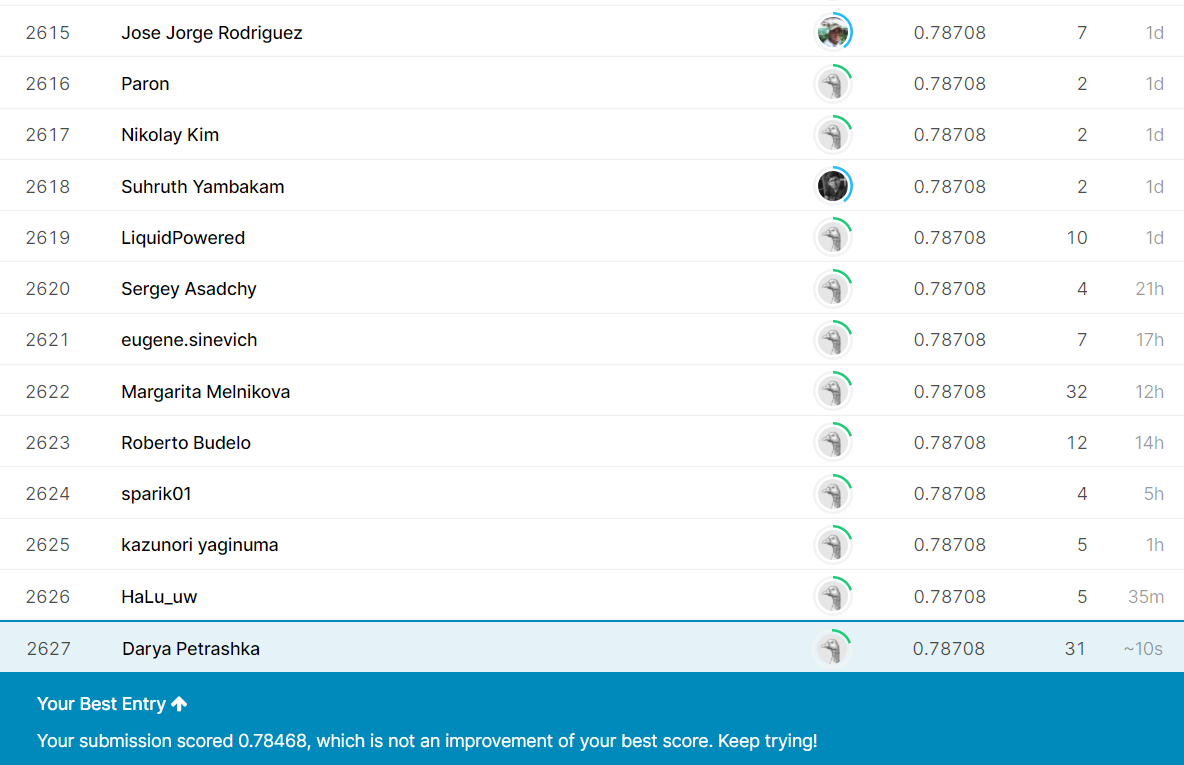

You can see my best score in the picture above. Here is my kaggle: https://www.kaggle.com/daryapetrashka

>>Bonus reading


I had an interesting idea - what if split data by sex and train models separately on women and men data?

Spoiler: it did not improve my score, rather the opposite.

In [51]:
data_women = data[data['Sex'] == 0]
data_men = data[data['Sex'] == 1]

In [52]:
y_w = data_women['Survived']
x_w = data_women[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [53]:
y_m = data_men['Survived']
x_m = data_men[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [54]:
main_model = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2000)
main_model.fit(x_w,y_w)
print(cross_val_score(main_model, x_w, y_w, scoring='accuracy', cv=5).mean())

0.8185355862775218


In [55]:
pipe_scaled = make_pipeline(StandardScaler(), main_model)
pipe_scaled.fit(x_w,y_w)
print(cross_val_score(pipe_scaled, x_w, y_w, scoring='accuracy', cv=5).mean())

0.8185355862775218


In [56]:
main_model = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2000)
main_model.fit(x_m,y_m)
print(cross_val_score(main_model, x_m, y_m, scoring='accuracy', cv=5).mean())

0.8093703148425788


In [57]:
pipe_scaled = make_pipeline(StandardScaler(), main_model)
pipe_scaled.fit(x_m,y_m)
print(cross_val_score(pipe_scaled, x_m, y_m, scoring='accuracy', cv=5).mean())

0.8093703148425788


In [58]:
knn = KNeighborsClassifier(n_neighbors=18)
pipe_scal = make_pipeline(StandardScaler(), knn)
pipe_scal.fit(x_w, y_w)
print('accuracy', cross_val_score(pipe_scal, x_w, y_w, scoring='accuracy', cv=5).mean())

accuracy 0.8026113671274961


In [59]:
knn = KNeighborsClassifier(n_neighbors=24)
pipe_scal = make_pipeline(StandardScaler(), knn)
pipe_scal.fit(x_m, y_m)
print('accuracy', cross_val_score(pipe_scal, x_m, y_m, scoring='accuracy', cv=5).mean())

accuracy 0.8232383808095951


>Wow, what an accuracy! I definitely need to check this model on kaggle!

In [60]:
test_women = test_data[test_data['Sex'] == 0]
test_men = test_data[test_data['Sex'] == 1]

In [61]:
test_w = test_women[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
test_m = test_men[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [62]:
predictions_women = pipe_scal.predict(test_w)
id_women = test_women['PassengerId'].array
preds_women = pd.DataFrame({'PassengerId':id_women, 'Survived':predictions_women})
predictions_women

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=int64)

In [63]:
predictions_men = pipe_scal.predict(test_m)
id_men = test_men['PassengerId'].array
preds_men = pd.DataFrame({'PassengerId':id_men, 'Survived':predictions_men})
predictions_men

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

>Hm. Only few people survived. Accuracy was 0.62918. Then I tried different thresholds in order to increase 1s quantity.

In [64]:
predictions_women = pipe_scal.predict(test_w)
THRESHOLD = 0.1
predictions_women = np.where(pipe_scal.predict_proba(test_w)[:,1] > THRESHOLD, 1, 0)
id_women = test_women['PassengerId'].array
preds_women = pd.DataFrame({'PassengerId':id_women, 'Survived':predictions_women})
predictions_women

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1])

In [65]:
predictions_men = pipe_scal.predict(test_m)
THRESHOLD = 0.4
predictions_men = np.where(pipe_scal.predict_proba(test_m)[:,1] > THRESHOLD, 1, 0)
id_men = test_men['PassengerId'].array
preds_men = pd.DataFrame({'PassengerId':id_men, 'Survived':predictions_men})
predictions_men

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0])

In [66]:
frames = [preds_men, preds_women]
result = pd.concat(frames)
result_sorted = result.sort_values('PassengerId')

In [67]:
#output = pd.DataFrame({'PassengerId': result.PassengerId, 'Survived': result.Survived})
output=result_sorted
output.to_csv('my_test.csv', index=False)

>My best result was 0.74401 with 0.1 and 0.4 thresholds for women and men respectively. This idea is not competitive.
I think there 2 reasons:
- we have a relatively small dataset
- dataset splitting damaged some patterns that the model saw earlier